# Mixture Density Networks

- Christopher M. Bishop
- Feb, 1994
- [Paper](https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf)
- 참고할 만한 [article](https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca)
- 참고할 만한 노트북: [1](https://github.com/dusenberrymw/mixture-density-networks/blob/master/mixture_density_networks.ipynb), [2](http://otoro.net/ml/ipynb/mixture/mixture.html)

## 핵심
- 머신러닝으로 하고 싶은 건, to model the underlying generator of the data
- 'Conventional least square' 방식은 한정적인 data samples로부터 maximum likelihood를 얻는 것에 주력
- 입력도 Gaussian이고 결과도 Gaussian을 따를 때 아름답게 학습된다
- (pp.3) 정확한 point를 regression하기 보다 distribution을 얻어내보자
- Mixture model에서는 어떤 dist든 조합할 수 있지만 MDN에서는 Gaussian의 조합으로 한정
- 각 Gaussian dist의 $\mu$와 $\sigma$, 그리고 Gaussian dist간의 가중치 $\alpha$까지 neural net을 통해 얻어내보자
- $\alpha$의 합은 1이 되어야 하므로 softmax를 통과
- $\mu$는 양수여야 하므로 $y = e^{x}$ 통과 (다른 함수를 사용해도 무관. 예를 들어 ELU(x)+1)

## 논문에 제시된 예제: conventional least square로 불가능한 문제
- $x = t + 0.3sin(2\pi t) + \epsilon$

In [1]:
import numpy as np

n = 2000  # 개의 points
t = np.random.uniform(0, 1, (n, 1)).astype(np.float32)
noise = np.random.uniform(-0.1, 0.1, (n, 1)).astype(np.float32)
x = t + 0.3 * np.sin(2 * np.pi * t) + noise

In [2]:
t

array([[0.3152676 ],
       [0.86771727],
       [0.29258117],
       ...,
       [0.14824486],
       [0.3411993 ],
       [0.26224646]], dtype=float32)

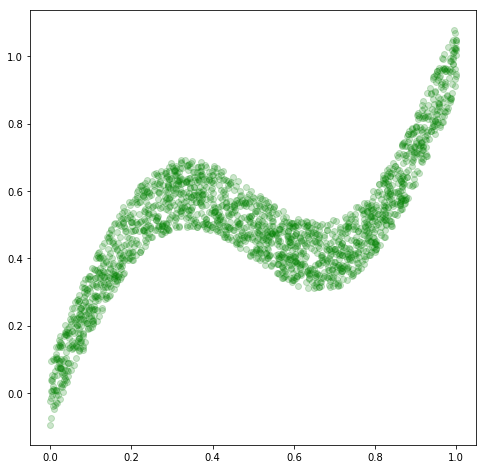

In [45]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(8, 8))
plt.plot(t, x, 'go', alpha=0.2)
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation

tf.enable_eager_execution()

N_HIDDEN = 64  # paper에서는 5

def get_model():
    model = tf.keras.models.Sequential()
    model.add(Dense(N_HIDDEN, input_dim=1))
    model.add(Activation(tf.nn.elu))  # paper에서는 tanh
    model.add(Dense(N_HIDDEN))
    model.add(Activation(tf.nn.elu))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')  # paper에서는 다른 optimization method 사용
    return model

m1 = get_model()
m1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [5]:
%time m1.fit(t, x, epochs=50, batch_size=10, shuffle=True)  # paper에서의 epochs는 1,000

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
2000/2000 [==============================] - 1s 522us/sample - loss: 0.0270
Epoch 2/50
2000/2000 [==============================] - 1s 339us/sample - loss: 0.0216s - lo
Epoch 3/50
2000/2000 [==============================] - 1s 303us/sample - loss: 0.0216
Epoch 4/50
2000/2000 [==============================] - 1s 305us/sample - loss: 0.0214
Epoch 5/50
2000/2000 [==============================] - 1s 293us/sample - loss: 0.0216
Epoch 6/50
2000/2000 [==============================] - 1s 303us/sample - loss: 0.0215
Epoch 7/50
2000/2000 [==============================] - 1s 291us/sample - loss: 0.0212
Epoch 8/50
2000/2000 [==============================] - 1s 291us/sample - loss: 0.0216
Epoch 9/50
2000/2000 [==============================] - 1s 289us/sample - loss: 0.0214
Epoch 10/50
2000/2000 [==============================] - 1s 284us/sample - loss: 0.0213
Epoch 11/50
2000/2000 [==============================] - 1s 301us/sample - 

In [47]:
test = np.linspace(0, 1, n).reshape(-1, 1).astype(np.float32)
out = m1.predict(test)
out

array([[0.02190926],
       [0.02307872],
       [0.02424858],
       ...,
       [0.99428314],
       [0.995543  ],
       [0.99680257]], dtype=float32)

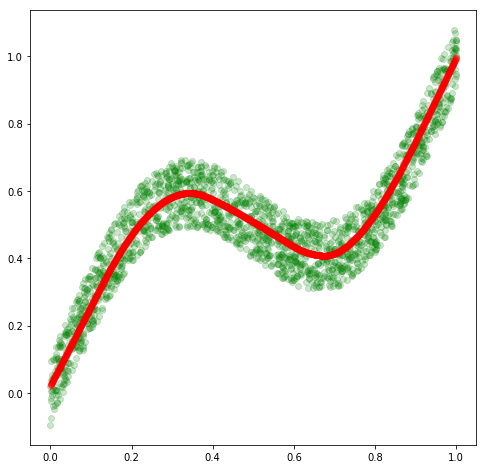

In [48]:
plt.figure(figsize=(8, 8))
plt.plot(t, x, 'go', alpha=0.2)
plt.plot(test, out, 'ro', alpha=0.2)
plt.show()

## One-to-one, many-to-one 문제는 잘 해결

- one-to-many가 되면? 단일 distribution으로는 표현할 수가 없다

In [8]:
m2 = get_model()
m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                128       
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_3 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


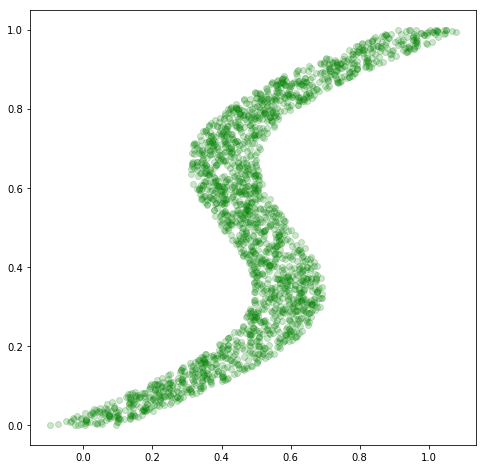

In [50]:
plt.figure(figsize=(8, 8))
plt.plot(x, t, 'go', alpha=0.2)
plt.show()

In [10]:
%time m2.fit(x, t, epochs=50, batch_size=10, shuffle=True)  # paper에서의 epochs는 1,000

Epoch 1/50
2000/2000 [==============================] - 1s 387us/sample - loss: 0.0565
Epoch 2/50
2000/2000 [==============================] - 1s 307us/sample - loss: 0.0496
Epoch 3/50
2000/2000 [==============================] - 1s 299us/sample - loss: 0.0502
Epoch 4/50
2000/2000 [==============================] - 1s 292us/sample - loss: 0.0495
Epoch 5/50
2000/2000 [==============================] - 1s 291us/sample - loss: 0.0498
Epoch 6/50
2000/2000 [==============================] - 1s 296us/sample - loss: 0.0491
Epoch 7/50
2000/2000 [==============================] - 1s 292us/sample - loss: 0.0495
Epoch 8/50
2000/2000 [==============================] - 1s 292us/sample - loss: 0.0499
Epoch 9/50
2000/2000 [==============================] - 1s 332us/sample - loss: 0.0490
Epoch 10/50
2000/2000 [==============================] - 1s 330us/sample - loss: 0.0496
Epoch 11/50
2000/2000 [==============================] - 1s 294us/sample - loss: 0.0493
Epoch 12/50
2000/2000 [==================

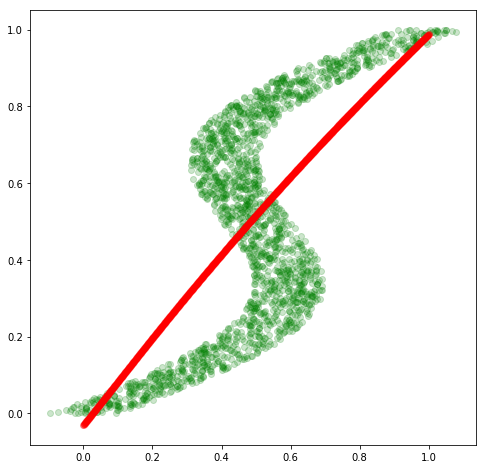

In [51]:
plt.figure(figsize=(8, 8))
plt.plot(x, t, 'go', alpha=0.2)
plt.plot(test, m2.predict(test), 'ro', alpha=0.2)
plt.show()

## The inverse problem을 MDN을 통해 해결해보자

In [12]:
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd

K = 5  # mixing components, # of kernels

def elu_plus_one(x):  # exp(x) 대신에 ELU(x)+1을 사용
    return tf.nn.elu(x) + 1

def gnll_loss(y, vec):
    alpha, mu, sigma = [vec[:,i*K:(i+1)*K] for i in range(3)]
    gm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=alpha),
                               components_distribution=tfd.Normal(loc=mu, scale=sigma))    
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)

def get_mdn_model():
    N_HIDDEN = 64
    
    inp = Input(shape=(1,))
    x = Dense(N_HIDDEN)(inp)
    x = Activation(tf.nn.elu)(x)
    x = Dense(N_HIDDEN)(x)
    x = Activation(tf.nn.elu)(x)  # 마지막 layer에서 1개의 값을 출력시키는 기존과 달리 K개의 alpha, mu, sigma를 출력하도록 한다
    b1 = Dense(K)(x)
    alpha = Activation(tf.nn.softmax)(b1)  # alpha의 합은 1이 되도록 softmax
    mu = Dense(K)(x)                       # mu는 그대로 사용
    b3 = Dense(K)(x)
    sigma = Activation(elu_plus_one)(b3)   # sigma는 양수가 되도록 ELU(x)+1
    out = Concatenate()([alpha, mu, sigma])   
    
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss=gnll_loss)
    return model

mdn = get_mdn_model()
mdn.summary()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 64)           128         input_1[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 64)           0           dense_6[0][0]                    
_______________________________________________________________________

In [13]:
%time mdn.fit(x, t, epochs=200, batch_size=10, shuffle=True)

Epoch 1/200
2000/2000 [==============================] - 1s 657us/sample - loss: -0.0193
Epoch 2/200
2000/2000 [==============================] - 1s 452us/sample - loss: -0.2276
Epoch 3/200
2000/2000 [==============================] - 1s 425us/sample - loss: -0.2967
Epoch 4/200
2000/2000 [==============================] - 1s 440us/sample - loss: -0.3519
Epoch 5/200
2000/2000 [==============================] - 1s 416us/sample - loss: -0.3921
Epoch 6/200
2000/2000 [==============================] - 1s 415us/sample - loss: -0.5952
Epoch 7/200
2000/2000 [==============================] - 1s 430us/sample - loss: -0.6096
Epoch 8/200
2000/2000 [==============================] - 1s 446us/sample - loss: -0.7084
Epoch 9/200
2000/2000 [==============================] - 1s 473us/sample - loss: -0.7477
Epoch 10/200
2000/2000 [==============================] - 1s 453us/sample - loss: -0.8014
Epoch 11/200
2000/2000 [==============================] - 1s 431us/sample - loss: -0.8173
Epoch 12/200
2000/2

2000/2000 [==============================] - 1s 436us/sample - loss: -0.9484
Epoch 93/200
2000/2000 [==============================] - 1s 435us/sample - loss: -0.9841
Epoch 94/200
2000/2000 [==============================] - 1s 434us/sample - loss: -0.9726
Epoch 95/200
2000/2000 [==============================] - 1s 445us/sample - loss: -0.9678
Epoch 96/200
2000/2000 [==============================] - 1s 450us/sample - loss: -0.9607
Epoch 97/200
2000/2000 [==============================] - 1s 436us/sample - loss: -0.9518
Epoch 98/200
2000/2000 [==============================] - 1s 444us/sample - loss: -0.9800
Epoch 99/200
2000/2000 [==============================] - 1s 419us/sample - loss: -0.9630
Epoch 100/200
2000/2000 [==============================] - 1s 443us/sample - loss: -0.9804
Epoch 101/200
2000/2000 [==============================] - 1s 424us/sample - loss: -0.9533
Epoch 102/200
2000/2000 [==============================] - 1s 441us/sample - loss: -0.9762
Epoch 103/200
2000/2

Epoch 182/200
2000/2000 [==============================] - 1s 481us/sample - loss: -1.0033
Epoch 183/200
2000/2000 [==============================] - 1s 459us/sample - loss: -1.0157
Epoch 184/200
2000/2000 [==============================] - 1s 447us/sample - loss: -0.9983
Epoch 185/200
2000/2000 [==============================] - 1s 431us/sample - loss: -1.0103
Epoch 186/200
2000/2000 [==============================] - 1s 430us/sample - loss: -1.0147
Epoch 187/200
2000/2000 [==============================] - 1s 435us/sample - loss: -1.0252
Epoch 188/200
2000/2000 [==============================] - 1s 443us/sample - loss: -1.0090
Epoch 189/200
2000/2000 [==============================] - 1s 421us/sample - loss: -1.0026
Epoch 190/200
2000/2000 [==============================] - 1s 467us/sample - loss: -1.0137
Epoch 191/200
2000/2000 [==============================] - 1s 483us/sample - loss: -1.0001
Epoch 192/200
2000/2000 [==============================] - 1s 436us/sample - loss: -1.0137

In [52]:
out = mdn.predict(test)
out.shape  # K가 5였으므로 15개가 출력 (5개의 alpha, 5개의 mu, 5개의 sigma)

(2000, 15)

In [53]:
out[0]

array([1.1273594e-12, 2.9635972e-03, 3.1602946e-03, 2.5343443e-03,
       9.9134177e-01, 1.8633778e-01, 9.4888651e-01, 3.3375284e-01,
       3.0147502e-01, 1.4725164e-02, 1.6734147e-01, 2.8663158e-02,
       4.7854125e-02, 1.7947686e-01, 1.8922865e-02], dtype=float32)

In [54]:
sum(out[0][:K])

1.0000000058218934

### 얻어낸 distribution을 통해 값을 25개씩 sampling

In [27]:
sample_means = []
sample_maxes = []
sample_mins = []
samples = []

for vec in out:
    alpha, mu, sigma = [vec[i*K:(i+1)*K] for i in range(3)]
    mixture = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=alpha),
                                    components_distribution=tfd.Normal(loc=mu, scale=sigma))
    extracted = mixture.sample(25).numpy()
    samples.append(extracted)
    sample_means.append(extracted.mean())
    sample_maxes.append(extracted.max())
    sample_mins.append(extracted.min())

len(samples)

2000

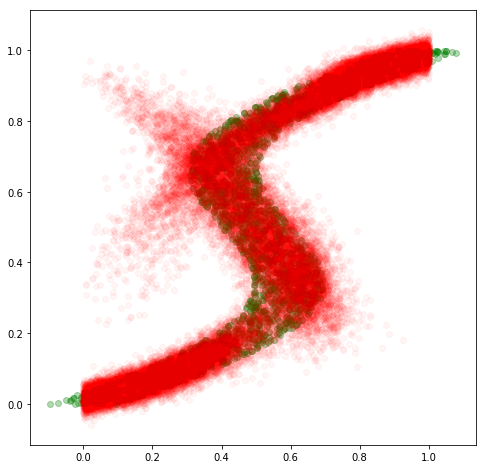

In [43]:
plt.figure(figsize=(8, 8))
plt.plot(x, t, 'go', alpha=0.3)
plt.plot(test, samples, 'ro', alpha=0.04)

plt.show()

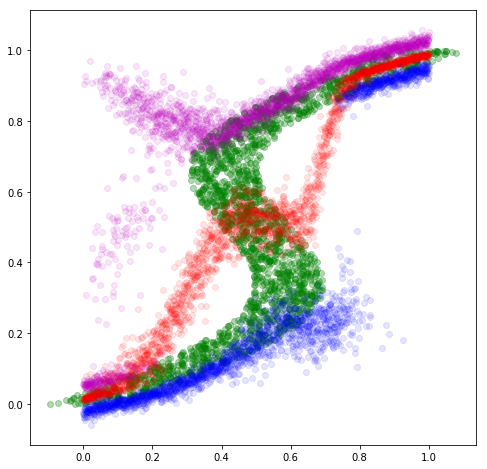

In [58]:
plt.figure(figsize=(8, 8))
plt.plot(x, t, 'go', alpha=0.3)
plt.plot(test, sample_means, 'ro', alpha=0.1)
plt.plot(test, sample_mins, 'bo', alpha=0.1)
plt.plot(test, sample_maxes, 'mo', alpha=0.1)

plt.show()

### Sampling values의 mean에 주목

- 위 그래프의 붉은점
- Least square를 이용했을 때 최적의 결과 (paper pp.15, figure 5)